In [1]:
from qcportal import PortalClient
from qcelemental.models.results import WavefunctionProtocolEnum
from openff.qcsubmit.results import OptimizationResultCollection,BasicResultCollection
from openff.qcsubmit.datasets import BasicDataset
from openff.qcsubmit.results.filters import ConnectivityFilter, ConformerRMSDFilter
from openff.qcsubmit.factories import BasicDatasetFactory
from openff.qcsubmit.common_structures import Metadata, QCSpec
import numpy as np
from openff.toolkit import Molecule
from matplotlib import pyplot as plt

# Download/process QCA Dataset

In [2]:
client = PortalClient("https://api.qcarchive.molssi.org:443/")

In [3]:
esp_50k_ds = BasicResultCollection.from_server(
    client=client,
    datasets=["OpenFF ESP Fragment Conformers v1.0"],
    spec_name="spec_1"
)

In [5]:
br_ds = BasicResultCollection.from_server(
    client=client,
    datasets=["OpenFF multi-Br ESP Fragment Conformers v1.1"],
    spec_name="HF/6-31G*"
)

In [6]:
i_ds = OptimizationResultCollection.from_server(
    client=client,
    datasets=["OpenFF Iodine Fragment Opt v1.0"],
    spec_name="default"
)

Not filtering the other DS because it's too big. I tested filtering after sub-sampling, and it only eliminated a few records. Hopefully not an issue for just benchmarking the timing.

In [7]:
filtered_br_ds = br_ds.filter(
    ConnectivityFilter(),
    ConformerRMSDFilter(rmsd_tolerance=0.05)
)

In [8]:
filtered_i_ds = i_ds.filter(
    ConnectivityFilter(),
    ConformerRMSDFilter(rmsd_tolerance=0.05)
)

In [9]:
print(esp_50k_ds.n_results,esp_50k_ds.n_molecules)
print(br_ds.n_results,br_ds.n_molecules)
print(filtered_br_ds.n_results,filtered_br_ds.n_molecules)

65116 49526
650 610
644 610


In [10]:
print(i_ds.n_results,i_ds.n_molecules)
print(filtered_i_ds.n_results,filtered_i_ds.n_molecules)

531 526
529 526


In [11]:
esp_50k_ds.n_results/(esp_50k_ds.n_results + filtered_br_ds.n_results + filtered_i_ds.n_results)

0.9823047564452624

In [12]:
filtered_br_ds.n_results/(esp_50k_ds.n_results + filtered_br_ds.n_results + filtered_i_ds.n_results)

0.009715035677110833

In [13]:
filtered_i_ds.n_results/(esp_50k_ds.n_results + filtered_br_ds.n_results + filtered_i_ds.n_results)

0.007980207877626756

Want ~1000 molecules for the benchmark dataset. For an even  distribution, would want approximately 98% (980 molecules) should be from the 50k ESP, 1% (10 molecules) from Multi-Br, and 1% (10 molecules) from the iodine dataset. 

However, we want more I representation to look out for potential errors during the calculations, so let's do 94% from 50k ESP, 1% from multi-Br, and 5% from I

## Explore ds

In [14]:
all_mols = [Molecule.from_mapped_smiles(mol.cmiles,allow_undefined_stereo=True) for mol in esp_50k_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [15]:
all_mols_br_filtered = [Molecule.from_mapped_smiles(mol.cmiles,allow_undefined_stereo=True) for mol in filtered_br_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [16]:
all_mols_i_filtered = [Molecule.from_mapped_smiles(mol.cmiles,allow_undefined_stereo=True) for mol in filtered_i_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [17]:
masses_50k = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in all_mols
])
print("ESP 50k MW (min, mean, max):", masses_50k.min(), masses_50k.mean(), masses_50k.max())

masses_multibr = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in all_mols_br_filtered
])
print("Br Filt MW (min, mean, max):", masses_multibr.min(), masses_multibr.mean(), masses_multibr.max())

ESP 50k MW (min, mean, max): 40.06412800000001 148.8372769343165 313.374798
Br Filt MW (min, mean, max): 201.84508399999999 294.10740457096273 466.5868909999999


In [18]:
masses_i = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in all_mols_i_filtered
])
print("I Filt MW (min, mean, max):", masses_i.min(), masses_i.mean(), masses_i.max())

I Filt MW (min, mean, max): 155.965768 242.60168397873346 316.94329700000003


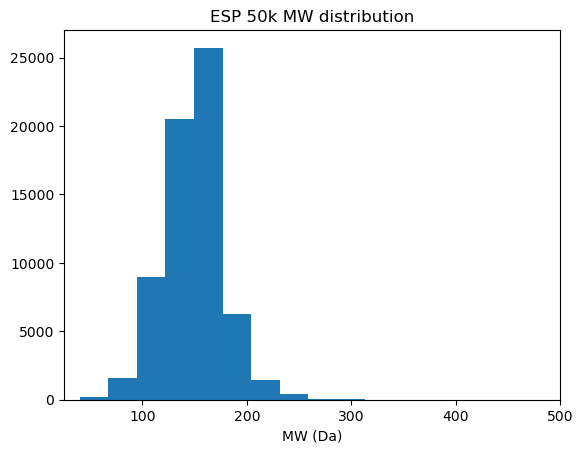

In [19]:
plt.figure()
plt.hist(masses_50k)
plt.xlim(25, 500)
plt.title('ESP 50k MW distribution')
plt.xlabel('MW (Da)')
plt.show()

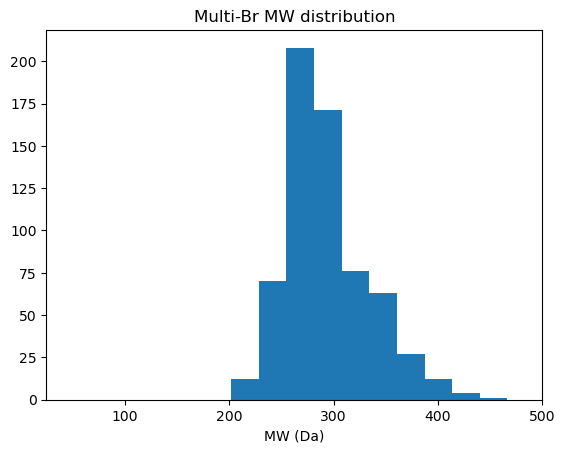

In [20]:
plt.figure()
plt.hist(masses_multibr)
plt.xlim(25, 500)
plt.title('Multi-Br MW distribution')
plt.xlabel('MW (Da)')
plt.show()

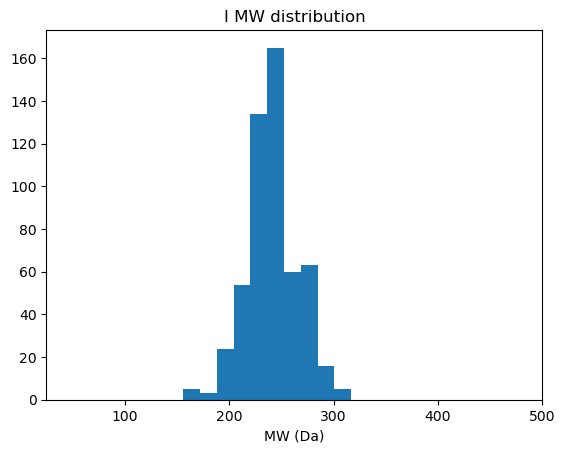

In [21]:
plt.figure()
plt.hist(masses_i)
plt.xlim(25, 500)
plt.title('I MW distribution')
plt.xlabel('MW (Da)')
plt.show()

In [22]:
esp_all_atoms = [atom.symbol
    for mol in all_mols
    for atom in mol.atoms]

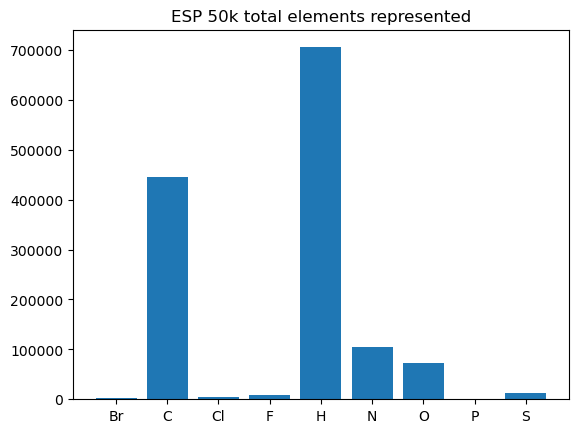

In [23]:
esp_all_atoms_labels, esp_all_atoms_counts = np.unique(esp_all_atoms,return_counts=True)
plt.plot()
plt.bar(esp_all_atoms_labels,esp_all_atoms_counts)
plt.title('ESP 50k total elements represented')
plt.show()

In [24]:
br_all_atoms = [atom.symbol
    for mol in all_mols_br_filtered
    for atom in mol.atoms]

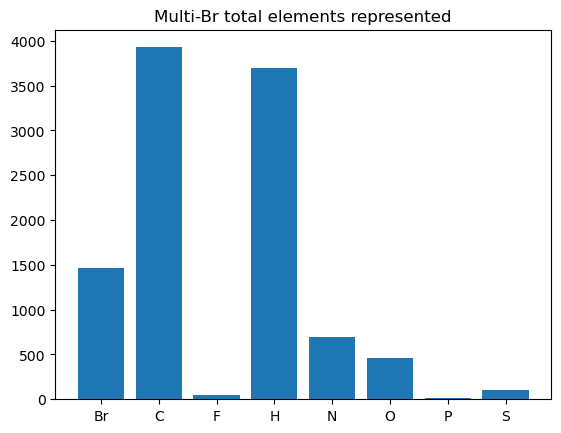

In [25]:
br_all_atoms_labels,br_all_atoms_counts = np.unique(br_all_atoms,return_counts=True)


plt.plot()
plt.bar(br_all_atoms_labels,br_all_atoms_counts)
plt.title('Multi-Br total elements represented')
plt.show()

In [26]:
i_all_atoms = [atom.symbol
    for mol in all_mols_i_filtered
    for atom in mol.atoms]

i_all_atoms_labels,i_all_atoms_counts = np.unique(i_all_atoms,return_counts=True)

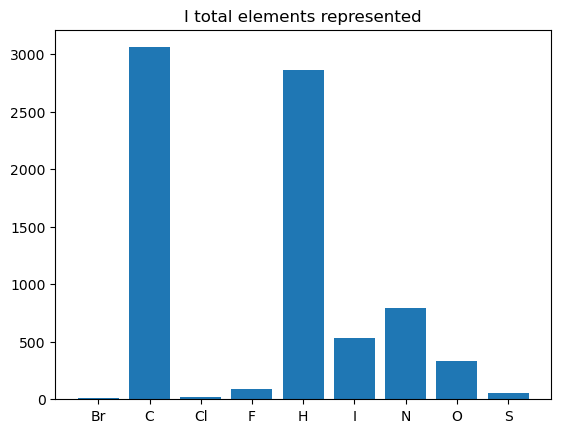

In [27]:
plt.plot()
plt.bar(i_all_atoms_labels,i_all_atoms_counts)
plt.title('I total elements represented')
plt.show()

In [28]:
atoms = []
for mol in all_mols:
    atoms.extend(np.unique([atom.symbol for atom in mol.atoms]))

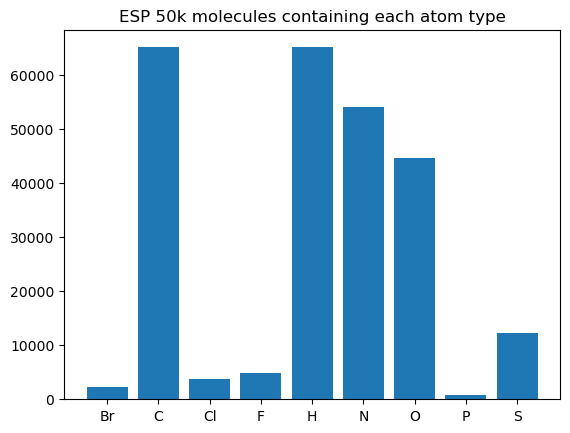

In [29]:
atoms_labels,atoms_counts = np.unique(atoms,return_counts=True)


plt.plot()
plt.bar(atoms_labels,atoms_counts)
plt.title("ESP 50k molecules containing each atom type")
plt.show()

In [30]:
atoms_br = []
for mol in all_mols_br_filtered:
    atoms_br.extend(np.unique([atom.symbol for atom in mol.atoms]))

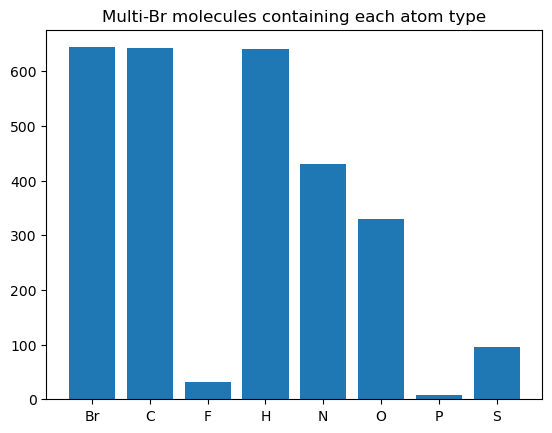

In [31]:
atoms_br_labels,atoms_br_counts = np.unique(atoms_br,return_counts=True)

plt.plot()
plt.bar(atoms_br_labels,atoms_br_counts)
plt.title("Multi-Br molecules containing each atom type")
plt.show()

In [32]:
atoms_i = []
for mol in all_mols_i_filtered:
    atoms_i.extend(np.unique([atom.symbol for atom in mol.atoms]))

atoms_i_labels,atoms_i_counts = np.unique(atoms_i,return_counts=True)

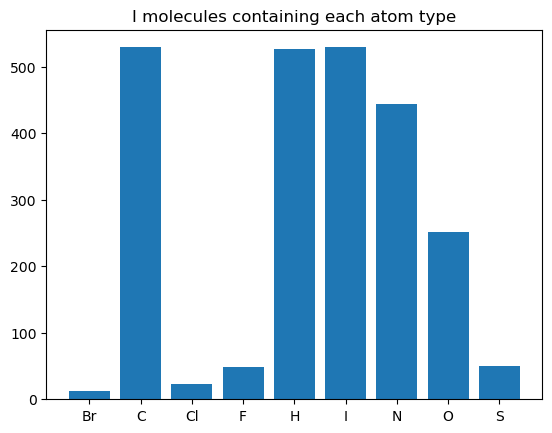

In [33]:
plt.plot()
plt.bar(atoms_i_labels,atoms_i_counts)
plt.title("I molecules containing each atom type")
plt.show()

# Sub-sample with deepchem

In [34]:
import deepchem as dc

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


This module requires PyTorch to be installed.


In [35]:
smiles_esp = [mol.to_smiles() for mol in all_mols]

In [36]:
qcaids_esp = [record.record_id for record in  esp_50k_ds.entries["https://api.qcarchive.molssi.org:443/"]]

In [37]:
dataset_esp50k=dc.data.NumpyDataset(smiles_esp,qcaids_esp)

In [38]:
smiles_br = [mol.to_smiles() for mol in all_mols_br_filtered]
qcaids_br = [record.record_id for record in filtered_br_ds.entries["https://api.qcarchive.molssi.org:443/"]]
dataset_br = dc.data.NumpyDataset(smiles_br, qcaids_br)

In [39]:
smiles_i = [mol.to_smiles() for mol in all_mols_i_filtered]
qcaids_i = [record.record_id for record in filtered_i_ds.entries["https://api.qcarchive.molssi.org:443/"]]
dataset_i = dc.data.NumpyDataset(smiles_i, qcaids_i)

## Random splitter

In [40]:
seed = 1234

In [41]:
random_splitter = dc.splits.RandomSplitter()

### ESP 50k dataset

In [79]:
ft_esp=.9855
x_esp,y_esp = random_splitter.train_test_split(dataset = dataset_esp50k, frac_train = ft_esp,seed=seed)#, frac_test = 0.5)
print(x_esp.X.shape[0],y_esp.X.shape[0])

64171 945


In [80]:
# from openff.toolkit import Molecule
masses_random_x_esp = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in x_esp.X
])
print("MW (min, mean, max):", masses_random_x_esp.min(), masses_random_x_esp.mean(), masses_random_x_esp.max())

MW (min, mean, max): 40.06412800000001 148.8398660303743 313.374798


In [81]:
# from openff.toolkit import Molecule
masses_random_y_esp = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in y_esp.X
])
print("MW (min, mean, max):", masses_random_y_esp.min(), masses_random_y_esp.mean(), masses_random_y_esp.max())

MW (min, mean, max): 58.10263600000002 148.6614622431746 265.930772


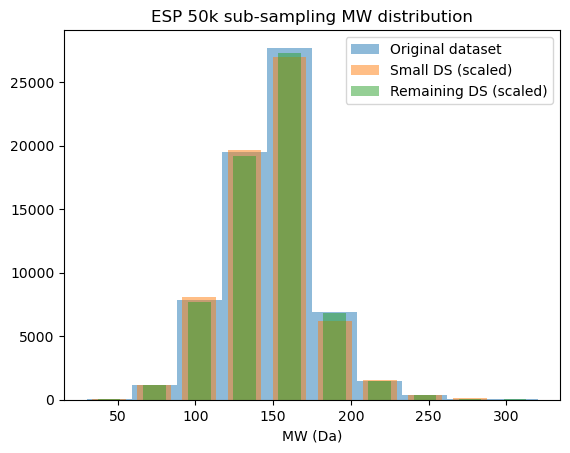

In [82]:
plt.figure()
plt.hist(masses_50k,alpha = 0.5,range=(30,320),label='Original dataset')
plt.hist(np.tile(masses_random_y_esp,int(1/(1-ft_esp))),alpha = 0.5,range=(30,320),rwidth=0.75,label='Small DS (scaled)')
plt.hist(np.tile(masses_random_x_esp,int(1/ft_esp)),alpha = 0.5,range=(30,320),rwidth=0.5,label='Remaining DS (scaled)')
plt.title('ESP 50k sub-sampling MW distribution')
plt.xlabel("MW (Da)")
plt.legend()
plt.show()

In [83]:
atoms_random_x_esp = []
for mol in x_esp.X:
    atoms_random_x_esp.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

atoms_random_y_esp = []
for mol in y_esp.X:
    atoms_random_y_esp.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

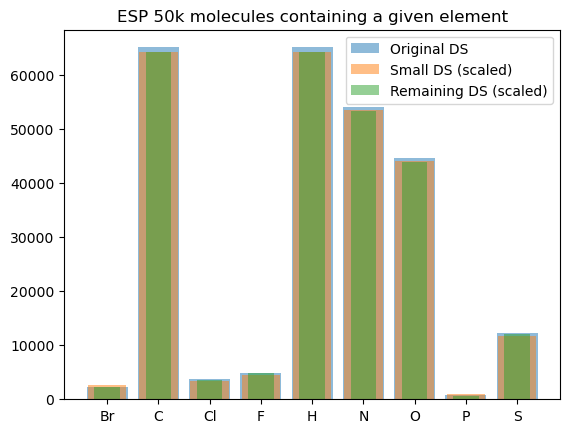

In [84]:
atoms_esp_labels,atoms_esp_counts = np.unique(atoms,return_counts=True)
atoms_random_x_esp_labels,atoms_random_x_esp_counts = np.unique(np.tile(atoms_random_x_esp,int(1/ft_esp)),return_counts=True)
atoms_random_y_esp_labels,atoms_random_y_esp_counts = np.unique(np.tile(atoms_random_y_esp,int(1/(1-ft_esp))),return_counts=True)

plt.figure()
plt.bar(atoms_esp_labels,atoms_esp_counts,alpha = 0.5,label='Original DS')
plt.bar(atoms_random_y_esp_labels,atoms_random_y_esp_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(atoms_random_x_esp_labels,atoms_random_x_esp_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("ESP 50k molecules containing a given element")
plt.show()

In [85]:
all_atoms_random_x_esp = [atom.symbol for mol in x_esp.X for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]

all_atoms_random_y_esp = []
for mol in y_esp.X:
    all_atoms_random_y_esp.extend([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])

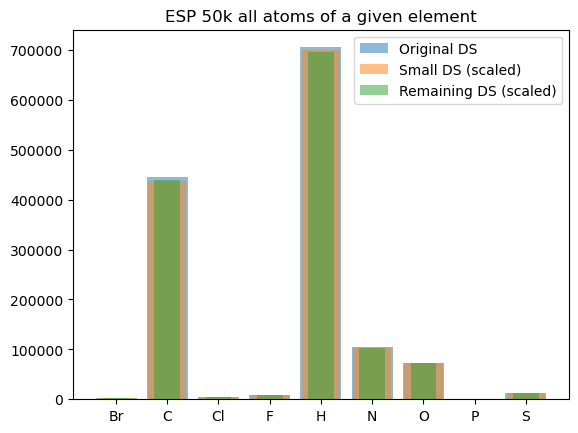

In [86]:
all_atoms_esp_labels,all_atoms_esp_counts = np.unique(esp_all_atoms,return_counts=True)
all_atoms_random_x_esp_labels,all_atoms_random_x_esp_counts = np.unique(np.tile(all_atoms_random_x_esp,int(1/ft_esp)),return_counts=True)
all_atoms_random_y_esp_labels,all_atoms_random_y_esp_counts = np.unique(np.tile(all_atoms_random_y_esp,int(1/(1-ft_esp))),return_counts=True)

plt.figure()
plt.bar(all_atoms_esp_labels,all_atoms_esp_counts,alpha = 0.5,label='Original DS')
plt.bar(all_atoms_random_y_esp_labels,all_atoms_random_y_esp_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(all_atoms_random_x_esp_labels,all_atoms_random_x_esp_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("ESP 50k all atoms of a given element")
plt.show()

### Multi-Br dataset
This will be harder to scale well since it's much smaller. Don't want to combine them, since the properties are so different.

In [52]:
ft_br=.984
x_br,y_br = random_splitter.train_test_split(dataset = dataset_br, frac_train = ft_br,seed=seed)#, frac_test = 0.5)
print(x_br.X.shape[0],y_br.X.shape[0])

633 11


In [53]:
# from openff.toolkit import Molecule
masses_random_x_br = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in x_br.X
])
print("MW (min, mean, max):", masses_random_x_br.min(), masses_random_x_br.mean(), masses_random_x_br.max())

MW (min, mean, max): 201.84508399999999 294.33477840039495 466.5868909999999


In [54]:
# from openff.toolkit import Molecule
masses_random_y_br = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in y_br.X
])
print("MW (min, mean, max):", masses_random_y_br.min(), masses_random_y_br.mean(), masses_random_y_br.max())

MW (min, mean, max): 237.88065400000002 281.0230742045455 329.81548799999996


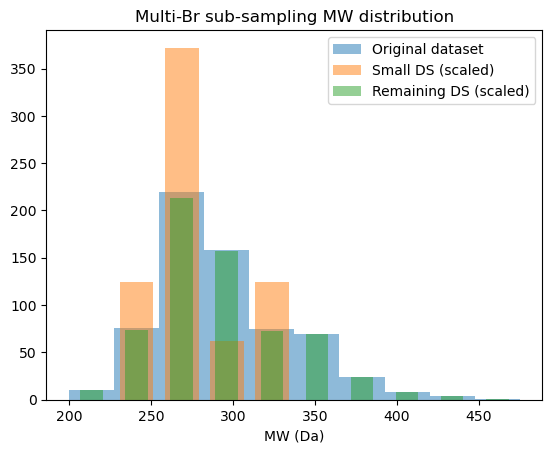

In [55]:
plt.figure()
plt.hist(masses_multibr,alpha = 0.5,range=(200,475),label='Original dataset')
plt.hist(np.tile(masses_random_y_br,int(1/(1-ft_br))),alpha = 0.5,range=(200,475),rwidth=0.75,label='Small DS (scaled)')
plt.hist(np.tile(masses_random_x_br,int(1/ft_br)),alpha = 0.5,range=(200,475),rwidth=0.5,label='Remaining DS (scaled)')
plt.title('Multi-Br sub-sampling MW distribution')
plt.xlabel("MW (Da)")
plt.legend()
plt.show()

In [56]:
atoms_random_x_br = []
for mol in x_br.X:
    atoms_random_x_br.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

atoms_random_y_br = []
for mol in y_br.X:
    atoms_random_y_br.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

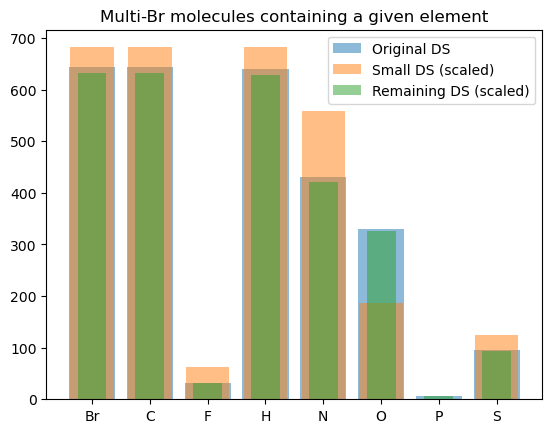

In [57]:
atoms_br_labels,atoms_br_counts = np.unique(atoms_br,return_counts=True)
atoms_random_x_br_labels,atoms_random_x_br_counts = np.unique(np.tile(atoms_random_x_br,int(1/ft_br)),return_counts=True)
atoms_random_y_br_labels,atoms_random_y_br_counts = np.unique(np.tile(atoms_random_y_br,int(1/(1-ft_br))),return_counts=True)

plt.figure()
plt.bar(atoms_br_labels,atoms_br_counts,alpha = 0.5,label='Original DS')
plt.bar(atoms_random_y_br_labels,atoms_random_y_br_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(atoms_random_x_br_labels,atoms_random_x_br_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("Multi-Br molecules containing a given element")
plt.show()

In [58]:
all_atoms_random_x_br = [atom.symbol for mol in x_br.X for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]

all_atoms_random_y_br = []
for mol in y_br.X:
    all_atoms_random_y_br.extend([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])

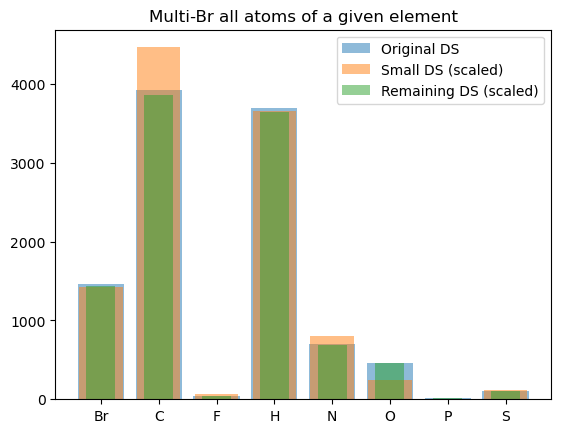

In [59]:
all_atoms_br_labels,all_atoms_br_counts = np.unique(br_all_atoms,return_counts=True)
all_atoms_random_x_br_labels,all_atoms_random_x_br_counts = np.unique(np.tile(all_atoms_random_x_br,int(1/ft_br)),return_counts=True)
all_atoms_random_y_br_labels,all_atoms_random_y_br_counts = np.unique(np.tile(all_atoms_random_y_br,int(1/(1-ft_br))),return_counts=True)

plt.figure()
plt.bar(all_atoms_br_labels,all_atoms_br_counts,alpha = 0.5,label='Original DS')
plt.bar(all_atoms_random_y_br_labels,all_atoms_random_y_br_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(all_atoms_random_x_br_labels,all_atoms_random_x_br_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("Multi-Br all atoms of a given element")
plt.show()

### I dataset
This will be harder to scale well since it's much smaller. Don't want to combine them, since the properties are so different.

In [60]:
ft_i=.9 # Want higher proportion of iodine molecules
x_i,y_i = random_splitter.train_test_split(dataset = dataset_i, frac_train = ft_i,seed=seed)#, frac_test = 0.5)
print(x_i.X.shape[0],y_i.X.shape[0])

476 53


In [61]:
# from openff.toolkit import Molecule
masses_random_x_i = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in x_i.X
])
print("MW (min, mean, max):", masses_random_x_i.min(), masses_random_x_i.mean(), masses_random_x_i.max())

MW (min, mean, max): 155.965768 242.35445039180672 316.94329700000003


In [62]:
# from openff.toolkit import Molecule
masses_random_y_i = np.array([
    sum([atom.mass.m for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])
    for mol in y_i.X
])
print("MW (min, mean, max):", masses_random_y_i.min(), masses_random_y_i.mean(), masses_random_y_i.max())

MW (min, mean, max): 165.960654 244.82212147641516 295.11864900000006


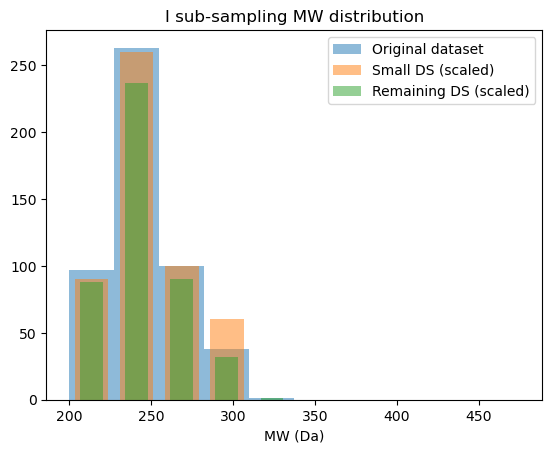

In [63]:
plt.figure()
plt.hist(masses_i,alpha = 0.5,range=(200,475),label='Original dataset')
plt.hist(np.tile(masses_random_y_i,int(1/(1-ft_i))),alpha = 0.5,range=(200,475),rwidth=0.75,label='Small DS (scaled)')
plt.hist(np.tile(masses_random_x_i,int(1/ft_i)),alpha = 0.5,range=(200,475),rwidth=0.5,label='Remaining DS (scaled)')
plt.title('I sub-sampling MW distribution')
plt.xlabel("MW (Da)")
plt.legend()
plt.show()

In [64]:
atoms_random_x_i = []
for mol in x_i.X:
    atoms_random_x_i.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

atoms_random_y_i = []
for mol in y_i.X:
    atoms_random_y_i.extend(np.unique([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]))

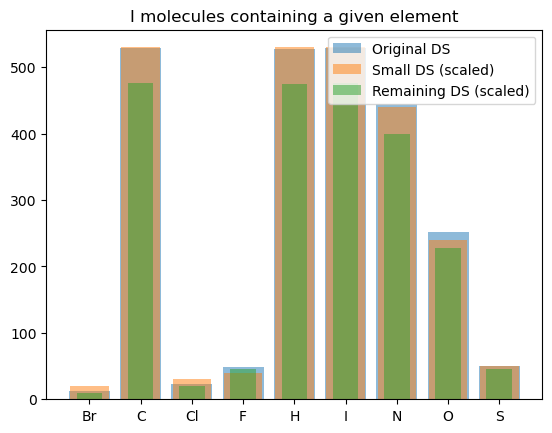

In [65]:
atoms_i_labels,atoms_br_counts = np.unique(atoms_i,return_counts=True)
atoms_random_x_i_labels,atoms_random_x_i_counts = np.unique(np.tile(atoms_random_x_i,int(1/ft_i)),return_counts=True)
atoms_random_y_i_labels,atoms_random_y_i_counts = np.unique(np.tile(atoms_random_y_i,int(1/(1-ft_i))),return_counts=True)

plt.figure()
plt.bar(atoms_i_labels,atoms_i_counts,alpha = 0.5,label='Original DS')
plt.bar(atoms_random_y_i_labels,atoms_random_y_i_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(atoms_random_x_i_labels,atoms_random_x_i_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("I molecules containing a given element")
plt.show()

In [66]:
all_atoms_random_x_i = [atom.symbol for mol in x_i.X for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms]

all_atoms_random_y_i = []
for mol in y_i.X:
    all_atoms_random_y_i.extend([atom.symbol for atom in Molecule.from_smiles(mol,allow_undefined_stereo=True).atoms])

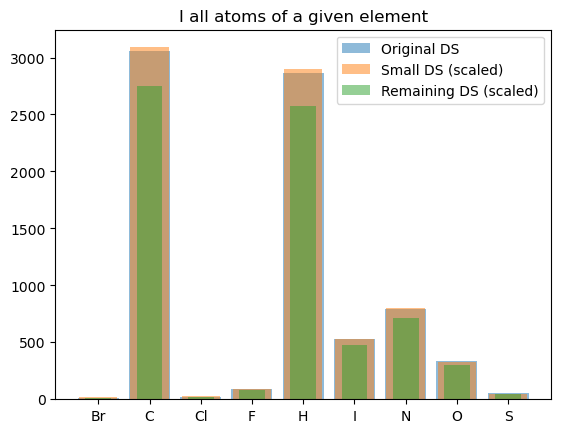

In [67]:
all_atoms_i_labels,all_atoms_i_counts = np.unique(i_all_atoms,return_counts=True)
all_atoms_random_x_i_labels,all_atoms_random_x_i_counts = np.unique(np.tile(all_atoms_random_x_i,int(1/ft_i)),return_counts=True)
all_atoms_random_y_i_labels,all_atoms_random_y_i_counts = np.unique(np.tile(all_atoms_random_y_i,int(1/(1-ft_i))),return_counts=True)

plt.figure()
plt.bar(all_atoms_i_labels,all_atoms_i_counts,alpha = 0.5,label='Original DS')
plt.bar(all_atoms_random_y_i_labels,all_atoms_random_y_i_counts,alpha = 0.5,width=0.75,label='Small DS (scaled)')
plt.bar(all_atoms_random_x_i_labels,all_atoms_random_x_i_counts,alpha = 0.5,width=0.5, label = 'Remaining DS (scaled)')
plt.legend()
plt.title("I all atoms of a given element")
plt.show()

# Save new dataset

In [87]:
esp_subsample_records = BasicResultCollection.parse_obj({'entries':{"https://api.qcarchive.molssi.org:443/":[record for record in esp_50k_ds.entries["https://api.qcarchive.molssi.org:443/"] if record.record_id in y_esp.y]}})

In [69]:
br_subsample_records = BasicResultCollection.parse_obj({'entries':{"https://api.qcarchive.molssi.org:443/":[record for record in filtered_br_ds.entries["https://api.qcarchive.molssi.org:443/"] if record.record_id in y_br.y]}})

In [88]:
esp_subsample_records_filter = esp_subsample_records.filter(
    ConnectivityFilter(),
    ConformerRMSDFilter(rmsd_tolerance=0.05)
)

In [89]:
print(esp_subsample_records.n_results,esp_subsample_records_filter.n_results)

945 945


Great, filter didn't affect anything too much.

In [90]:
with open('esp_subsample_filtered.json','w') as writefile:
    writefile.write(esp_subsample_records_filter.json(indent=2))

In [73]:
with open('br_subsample_filtered.json','w') as writefile:
    writefile.write(br_subsample_records.json(indent=2))

In [74]:
i_subsample_records = OptimizationResultCollection.parse_obj({'entries':{"https://api.qcarchive.molssi.org:443/":[record for record in filtered_i_ds.entries["https://api.qcarchive.molssi.org:443/"] if record.record_id in y_i.y]}})

In [75]:
i_subsample_to_basic = i_subsample_records.to_basic_result_collection(driver='gradient')

In [76]:
print(i_subsample_records.n_results,i_subsample_to_basic.n_results)

53 53


In [77]:
with open('i_subsample_filtered.json','w') as writefile:
    writefile.write(i_subsample_to_basic.json(indent=2))